# Running TCAV


This notebook walks you through things you need to run TCAV. In high level, you need:

1. **example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **model wrapper**: an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **act_generator**: an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model



## Requirements

    pip install the tcav and tensorflow packages (or tensorflow-gpu if using GPU)

In [3]:
sess.close()

NameError: name 'sess' is not defined

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

## Step 1. Store concept and target class images to local folders

and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 


You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [3]:
# folder prefix
# Mac
prefix = '/Users/justina/Documents/EPFL/thesis/projects/hnsc/histoXai/ace_small_test'
# Ubuntu
# prefix = '/usr/local/google/home/beenkim'

print ('REMEMBER TO UPDATE FOLDER PREFIX!')

REMEMBER TO UPDATE FOLDER PREFIX!


In [4]:
# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
import os
# model_to_run = 'GoogleNet'
# model_to_run = 'InceptionV3'
model_to_run = 'XceptionHPV'
user = 'justina'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test_xception'
working_dir = os.path.join(prefix , "tmp/{}/{}".format(user, project_name))
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  os.path.join(working_dir, 'activations/')
# where CAVs are stored.
# You can say None if you don't wish to store any.
cav_dir = os.path.join(working_dir,'cavs/')
# where the images live.
source_dir = os.path.join(prefix, "source_dir")
bottlenecks = [ 'mixed4c']  # @param
# bottlenecks = 
print(activation_dir)
print(working_dir)
print(cav_dir)
print(source_dir)
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs.
alphas = [0.1]

target = 'zebra'
concepts = ["dotted","striped","zigzagged"]

/Users/justina/Documents/EPFL/thesis/project/hnsc/histoXai/imagenet_small_test/tmp/justina/tcav_class_test_inception/activations/
/Users/justina/Documents/EPFL/thesis/project/hnsc/histoXai/imagenet_small_test/tmp/justina/tcav_class_test_inception
/Users/justina/Documents/EPFL/thesis/project/hnsc/histoXai/imagenet_small_test/tmp/justina/tcav_class_test_inception/cavs/
/Users/justina/Documents/EPFL/thesis/project/hnsc/histoXai/imagenet_small_test/source_dir


## Step 2. Write your model wrapper

Next step is to tell TCAV how to communicate with your model. See `model.GoolgeNetWrapper_public ` for details.

You can define a subclass of ModelWrapper abstract class to do this. Let me walk you thru what each function does (tho they are pretty self-explanatory).  This wrapper includes a lot of the functions that you already have, for example, `get_prediction`.

### 1. Tensors from the graph: bottleneck tensors and ends
First, store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. You only need bottlenecks that you are interested in running TCAV with. Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2. Define loss
Get your loss tensor, and assigned it to `self.loss`. This is what TCAV uses to take directional derivatives. 

While doing so, you would also want to set 
```python
self.y_input 
```
this simply is a tensorflow place holder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat).
For multi-class classification, typically something like this works:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

For example, for a multiclass classifier, something like below would work. 

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 3. Call _make_gradient_tensors in __init__() of your wrapper
```python
_make_gradient_tensors()  
```
does what you expect - given the loss and bottleneck tensors defined above, it adds gradient tensors.

### 4. Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format.

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

Set your input image shape at  `self.image_shape`


Set your model name to `self.model_name`

You are done with writing the model wrapper! I wrote two model wrapers, InceptionV3 and Googlenet.


**sess**: a tensorflow session.

In [5]:
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
# GRAPH_PATH =  os.path.join(prefix, "graph/tensorflow_inception_graph.pb")
GRAPH_PATH=os.path.join("/Users/justina/Documents/EPFL/thesis/project/hnsc/histoXai/tcav","./inceptionv3.pb")
# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy
# kit fox
# English setter
# Siberian husky ...

LABEL_PATH = os.path.join(prefix, "graph/imagenet_comp_graph_label_strings.txt")

# mymodel = model.GoolgeNetWrapper_public(sess,
#                                         GRAPH_PATH,
#                                         LABEL_PATH)
mymodel=model.InceptionV3Wrapper_public(sess, GRAPH_PATH, LABEL_PATH)

INFO:tensorflow:Loading from frozen binary graph.
Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Step 3. Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [6]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## You are ready to run TCAV!

Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores. 


In [9]:
tf.logging.set_verbosity(0)
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
bottlenecks= ['mixed0_2', 'mixed1_2', 'mixed2_2','mixed3_2','mixed4_2','mixed5_2', 'mixed6_2','mixed7_2','mixed8_2','mixed9_3','mixed10_2']
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

This may take a while... Go get coffee!


KeyboardInterrupt: 

Class = zebra
  Concept = dotted
    Bottleneck = mixed2_2. TCAV Score = 0.42 (+- 0.07), random was 0.50 (+- 0.10). p-val = 0.023 (significant)
  Concept = striped
    Bottleneck = mixed2_2. TCAV Score = 0.45 (+- 0.12), random was 0.50 (+- 0.10). p-val = 0.177 (not significant)
  Concept = zigzagged
    Bottleneck = mixed2_2. TCAV Score = 0.61 (+- 0.08), random was 0.50 (+- 0.10). p-val = 0.002 (significant)
{'mixed2_2': {'bn_vals': [0.41999999999999993, 0.01, 0.6050000000000001], 'bn_stds': [0.0714142842854285, 0, 0.08200609733428361], 'significant': [True, False, True]}}


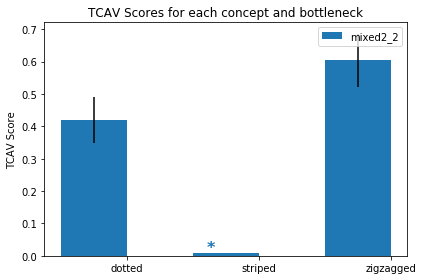

In [8]:
plot_data = utils_plot.plot_results(results, num_random_exp=10, 'inceptionv3_tcav.png')

Class = zebra
  Concept = dotted
    Bottleneck = mixed8_2. TCAV Score = 0.74 (+- 0.15), random was 0.49 (+- 0.25). p-val = 0.003 (significant)
  Concept = striped
    Bottleneck = mixed8_2. TCAV Score = 0.67 (+- 0.12), random was 0.49 (+- 0.25). p-val = 0.031 (significant)
  Concept = zigzagged
    Bottleneck = mixed8_2. TCAV Score = 0.49 (+- 0.21), random was 0.49 (+- 0.25). p-val = 0.953 (not significant)
{'mixed8_2': {'bn_vals': [0.74, 0.67, 0.01], 'bn_stds': [0.14966629547095764, 0.12083045973594571, 0], 'significant': [True, True, False]}}


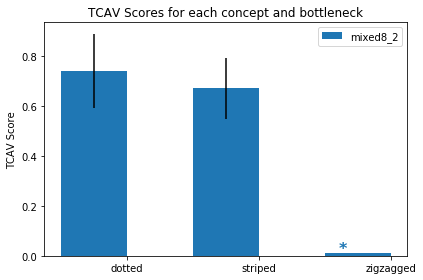

In [43]:

utils_plot.plot_results(results, num_random_exp=10)

In [3]:
import tensorflow as tf
from tensorflow.python.framework import graph_io
from tensorflow.keras.applications.inception_v3 import InceptionV3


def freeze_graph(graph, session, output):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, ".", "xception_hpv.pb", as_text=False)

tf.keras.backend.set_learning_phase(0) # this line most important

# base_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
#                                                include_top=True,
#                                                weights='imagenet')
# base_model.compile(loss='sparse_categorical_crossentropy',
#                 optimizer=tf.keras.optimizers.Adam())
keras_model_path = "/Users/justina/Documents/EPFL/thesis/projects/hnsc/trained_model.h5"

base_model = tf.keras.models.load_model(keras_model_path, compile=False)
base_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam())
session = tf.keras.backend.get_session()

INPUT_NODE = base_model.inputs[0].op.name
OUTPUT_NODE = base_model.outputs[0].op.name
freeze_graph(session.graph, session, [out.op.name for out in base_model.outputs])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 238 variables.
INFO:tensorflow:Converted 238 variables to const ops.


In [3]:
# import tensorflow as tf
# model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
#                                                include_top=True,
#                                                weights='imagenet')
# model.save('../imagenet_small_test/model2', save_format="tf")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../imagenet_small_test/model2/assets


In [22]:
from tensorflow.python.platform import gfile

sess = utils.create_session()

# f = gfile.FastGFile("../ace_small_test/xception_hpv.pb", 'rb')
# graph_def = tf.GraphDef()
# # Parses a serialized binary message into the current message.
# graph_def.ParseFromString(f.read())
# print(graph_def.node)
# f.close()
# sess.graph.as_default()
# tf.import_graph_def(graph_def)
# for op in sess.graph.get_operations():
#     print(op.name)
#     print(op.values())

with sess.graph.as_default():
    input_graph_def = tf.GraphDef()
    with tf.gfile.FastGFile("../ace_small_test/graphs/xception_hpv.pb", 'rb') as f:
        input_graph_def.ParseFromString(f.read())
        tf.import_graph_def(input_graph_def)
    LOGDIR='./logs/tests/xception_hpv/'
    train_writer = tf.summary.FileWriter(LOGDIR)
    train_writer.add_graph(sess.graph)    

import/block1_conv1/kernel
(<tf.Tensor 'import/block1_conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32>,)
import/block1_conv1_bn/gamma
(<tf.Tensor 'import/block1_conv1_bn/gamma:0' shape=(32,) dtype=float32>,)
import/block1_conv1_bn/beta
(<tf.Tensor 'import/block1_conv1_bn/beta:0' shape=(32,) dtype=float32>,)
import/block1_conv1_bn/moving_mean
(<tf.Tensor 'import/block1_conv1_bn/moving_mean:0' shape=(32,) dtype=float32>,)
import/block1_conv1_bn/moving_variance
(<tf.Tensor 'import/block1_conv1_bn/moving_variance:0' shape=(32,) dtype=float32>,)
import/block1_conv2/kernel
(<tf.Tensor 'import/block1_conv2/kernel:0' shape=(3, 3, 32, 64) dtype=float32>,)
import/block1_conv2_bn/gamma
(<tf.Tensor 'import/block1_conv2_bn/gamma:0' shape=(64,) dtype=float32>,)
import/block1_conv2_bn/beta
(<tf.Tensor 'import/block1_conv2_bn/beta:0' shape=(64,) dtype=float32>,)
import/block1_conv2_bn/moving_mean
(<tf.Tensor 'import/block1_conv2_bn/moving_mean:0' shape=(64,) dtype=float32>,)
import/block1_conv2_bn/m

In [17]:
%load_ext tensorboard
%tensorboard --logdir logs/tests/xception_hpv/

The tensorboard module is not an IPython extension.


UsageError: Line magic function `%tensorboard` not found.
